<a href="https://colab.research.google.com/github/metahwi/MachineLearning/blob/main/Convolutional%20and%20Recurrent%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional and Recurrent Neural Networks


This notebook aims to convolutional and recurrent neural networks with practical examples in image and text classification problems.

# Image classification using Convolutional Neural Networks (CNNs)

Convolutional networks are very powerful feature extractors and they contain many properties that allow integrate many concepts related to cognitive approaches to decision making into the design of representation learning models, including

* **Compositionality**, combining representations of features together by combining many layers
* **Locality and stationarity** especially useful for images with localized or positional information
* **Invariance** of object class to translations assumed by the pooling layers

Let's start exploring CNNs in PyTorch by setting up the environment and importing the functional packages.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/MyDrive/473-Fall23-Recitation/Fall2023-473-Lab9')
from plot_lib import plot_data, plot_model, set_default

set_default()

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

Mounted at /content/gdrive/


If you have GPUs available PyTorch makes it particularly easy for us to make use of GPUs to speed up computation, so long as it can correctly find whether the GPU exists in the architecture or not.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load the Dataset (MNIST)

The MNIST (Modified National Institute of Standards and Technology) database contains a large collection of images from handwritten digits, and it is one of the most commonly used machine learning evaluation benchmarks.

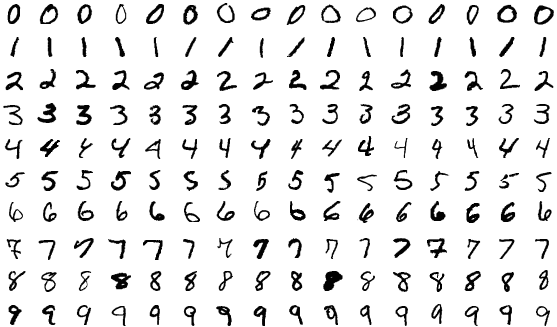

We can load the MNIST handwritten digits dataset using the PyTorch DataLoader utilities. After downloading, the program will shuffle, normalize data and arrange it in batches so they can appropriately be used in training the machine learning models.

Normalizing image data typically involves subtracting some coefficient (usually the mean) from each pixel values and dividing the resulting pixel values by another coefficient (usually the variance of the original pixel values).

In [ ]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 79071040.51it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41343240.21it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20654933.54it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4040409.07it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



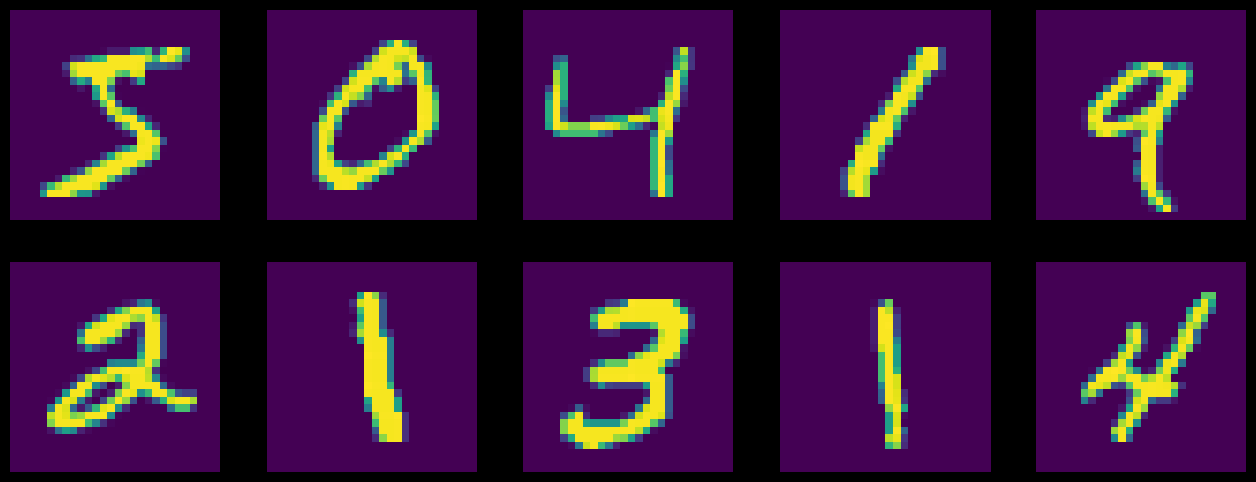

In [ ]:
# Visualize some images from the database
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

### Create the model classes

We will create and demonstrate performance in image classification using two model classes:
1. Multi-layer Perceptron
2. Convolutional Neural Network

An important remark to remember specific to defining CNNs will be to pay special attention to the order of the layers.

In [ ]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x) # Will it make a difference if we apply the non-linearity after the pooling layer?
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4) # this is where are flattening the 2D feature maps into a single 1D vector so as to be used by the subsequent fully connected layer
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is available, falling back to CPU if not:

In [ ]:
accuracy_list = []
def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data to device, where the "device" is either a GPU if it exists or a CPU
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        # forward pass through the model
        output = model(data)
        # forward pass through the cross-entropy loss function
        loss = F.nll_loss(output, target)
        # backward pass through the cross-entropy loss function and the model
        loss.backward()

        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # send data to device, where the "device" is either a GPU if it exists or a CPU
            data, target = data.to(device), target.to(device)

            # permute pixels
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
        accuracy_list.append(accuracy)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            accuracy))

### Train a small MLP

In [ ]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.276132
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.915201
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.574059
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.037353
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.915652
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.624649
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.546561
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.658995
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.454066
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.705554

Test set: Average loss: 0.4982, Accuracy: 8516/10000 (85%)



### Train a CNN with the same number of parameters

Make sure to clarify your understanding on how the model works by changing the hyper-parameters and observing their relationship with model performance.

In [ ]:
# Training settings
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.326606
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.167509
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.649385
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.414228
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.304659
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.270817
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.129067
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.297089
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.250423
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.354965

Test set: Average loss: 0.1866, Accuracy: 9420/10000 (94%)



CNN performs better with the same number of parameters, thanks to its use of prior knowledge about images:

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

## What happens if the assumptions are no longer true?

Let us break the assumption of locality and permute the pixel within each image using an arbitrary permutation matrix. We can visualize the experiment by displaying the permuted images.

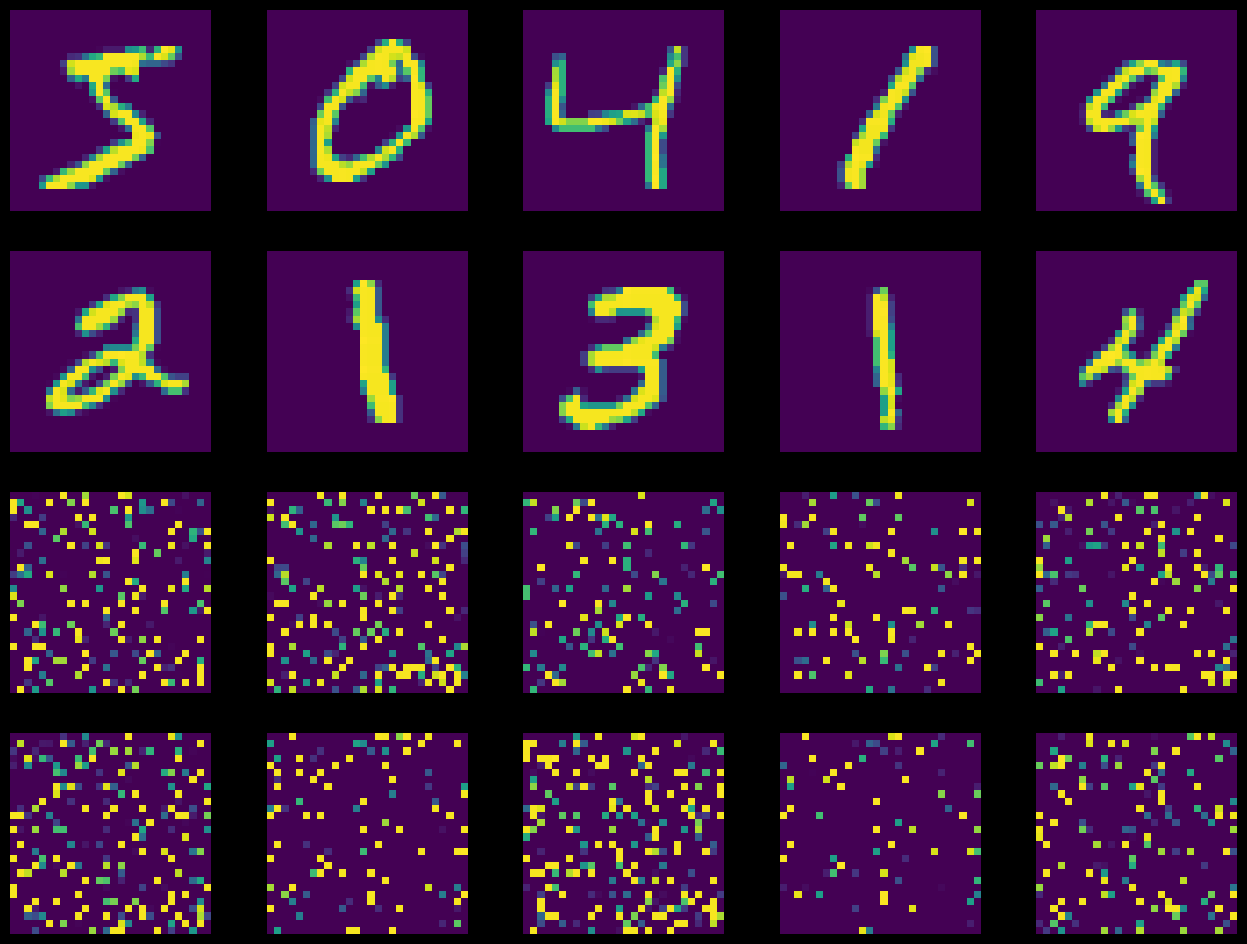

In [ ]:
torch.manual_seed(1)
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

### CNNs with permuted pixels
What do you think will happen to CNNs when given permuted pixels as inputs?

In [ ]:
# Training settings
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.291229
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.291532
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.211863
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.807913
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.519811
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.965762
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.850661
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.729582
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.653588
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.525966

Test set: Average loss: 0.5638, Accuracy: 8225/10000 (82%)



### MLPs with permuted pixels

In [ ]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.294153
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.991550
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.672047
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.388871
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.753607
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.790892
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.482573
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.680768
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.541100
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.568139

Test set: Average loss: 0.5189, Accuracy: 8816/10000 (88%)



### The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

<ipython-input-15-906b3b8928ae>:7: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(20)


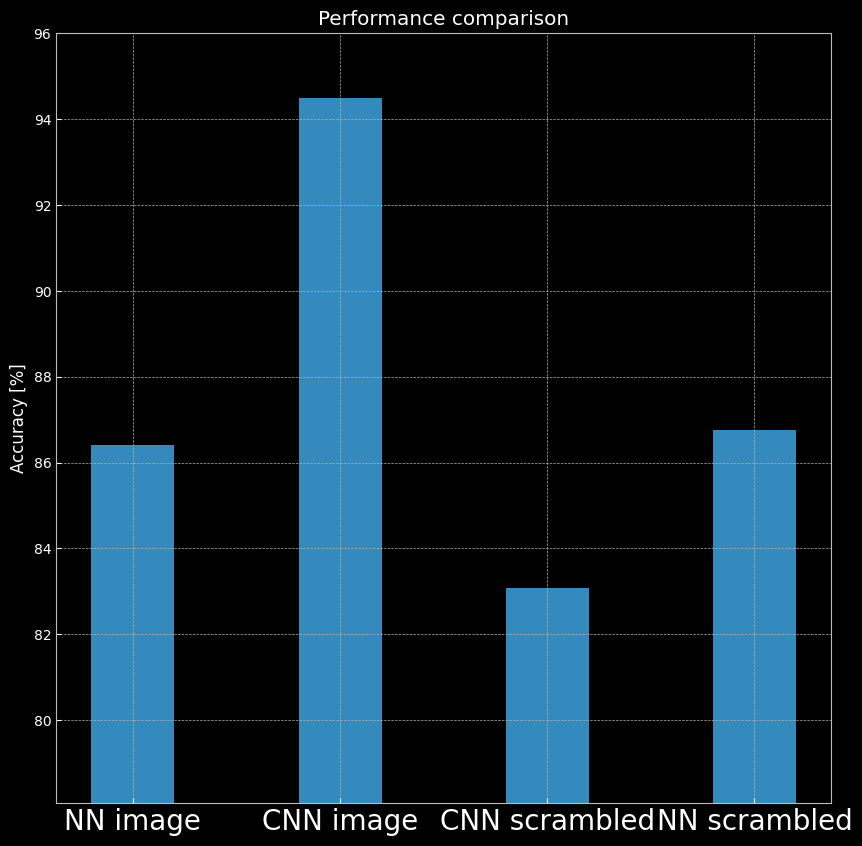

In [ ]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Performance comparison');

### Checking Model Parameters

In [ ]:
print(model_cnn)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=96, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
print(model_fnn)

FC2Layer(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)


# Text classification using Recurrent Neural Networks (RNNs)

In the next part, we will introduce RNNs which are very useful models for processing sequential input, such as applications in natural language processing.

Our classification task will involve automatically labeling the sentiment of movie reviews. For building our model we will use the [Large Movie Review Dataset](https://keras.io/api/datasets/imdb/).

### Dataset Exploration

Let's load the review data and see how the input and labels look like.

In [ ]:
!pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.8 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [ ]:
import torch
from torchtext import data

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
LABEL = data.LabelField(dtype = torch.float)

In [ ]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


We can inspect the samples from the data set using the training and testing sets.

In [ ]:
print(vars(train_data.examples[0]))

{'text': ['Most', 'people', ',', 'especially', 'young', 'people', ',', 'may', 'not', 'understand', 'this', 'film', '.', 'It', 'looks', 'like', 'a', 'story', 'of', 'loss', ',', 'when', 'it', 'is', 'actually', 'a', 'story', 'about', 'being', 'alone', '.', 'Some', 'people', 'may', 'never', 'feel', 'loneliness', 'at', 'this', 'level.<br', '/><br', '/>Cheadles', 'character', 'Johnson', 'reflected', 'the', 'total', 'opposite', 'of', 'Sandlers', 'character', 'Fineman', '.', 'Where', 'Johnson', 'felt', 'trapped', 'by', 'his', 'blessings', ',', 'Fineman', 'was', 'trying', 'to', 'forget', 'his', 'life', 'in', 'the', 'same', 'perspective', '.', 'Jada', 'is', 'a', 'wonderful', 'additive', 'to', 'the', 'cast', 'and', 'Sandler', 'pulls', 'tears', '.', 'Cheadle', 'had', 'the', 'comic', 'role', 'and', 'was', 'a', 'great', 'supporter', 'for', 'Sandler.<br', '/><br', '/>I', 'see', 'Oscars', 'somewhere', 'here', '.', 'A', 'very', 'fine', 'film', '.', 'If', 'you', 'have', 'ever', 'lost', 'and', 'felt', 'a

In order to process the input we will first represent each word in terms of a number, identifying it in the English vocabulary. We will build a vocabulary and convert each word to a unique number using the training data set.


In [ ]:
TEXT.build_vocab(train_data, max_size=5000)
LABEL.build_vocab(train_data)

# Let's see what the top 10 words in the vocabulary are
print(TEXT.vocab.freqs.most_common(10))

[('the', 202206), (',', 192694), ('.', 165632), ('a', 108861), ('and', 108774), ('of', 100554), ('to', 93353), ('is', 76363), ('in', 61315), ('I', 54289)]


Finally, for representing our training data in batches, we will create iterators as we did in previous recitations.

In [ ]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)

### Define the Model

Let's now define the RNN model and its parameters that we will use for sentiment classification.

In [ ]:
import torch
import torch.nn as nn

# Set the random seed for reproducible results
torch.manual_seed(1)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        # This just calls the base class constructor
        super().__init__()
        # Neural network layers assigned as attributes of a Module subclass
        # have their parameters registered for training automatically.
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = torch.nn.RNN(embedding_size, hidden_size)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The RNN also returns its hidden state but we don't use it.
        # While the RNN can also take a hidden state as input, the RNN
        # gets passed a hidden state initialized with zeros by default.
        w = self.embedding(x)
        o, h = self.rnn(w)
        return self.linear(h.squeeze(0))


In [ ]:
input_size = len(TEXT.vocab)
embedding_size = 50
hidden_size = 50
output_size = 1

model = SimpleRNN(input_size, embedding_size, hidden_size, output_size)

### Training Loop

In [ ]:
from sklearn.metrics import accuracy_score

def train(model, criterion, optimizer, iterator):

    epoch_loss = 0
    epoch_acc = 0

    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
    for batch in iterator:

        preds = model(batch.text).squeeze(1)
        loss = criterion(preds, batch.label)

        rounded_preds = torch.round(torch.sigmoid(preds))

        preds_np = rounded_preds.detach()
        labels_np = batch.label.detach()
        acc = accuracy_score(preds_np, labels_np)

        # the backward pass over the loss and the model
        loss.backward()

        # the gradient step to update the weights
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Testing Loop

In [ ]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:

            preds = model(batch.text).squeeze(1)
            loss = criterion(preds, batch.label)

            rounded_preds = torch.round(torch.sigmoid(preds))
            acc = accuracy_score(rounded_preds, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import torch.optim as optim

epochs = 5
learning_rate = 1e-3

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

for epoch in range(epochs):

    train_loss, train_acc = train(model, criterion, optimizer, train_iterator)

    print(f'Epoch: {epoch+1:02} | \tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')


Epoch: 01 | 	Train Loss: 0.694 | Train Acc: 50.31%
Epoch: 02 | 	Train Loss: 0.693 | Train Acc: 50.16%
Epoch: 03 | 	Train Loss: 0.693 | Train Acc: 50.02%
Epoch: 04 | 	Train Loss: 0.693 | Train Acc: 50.60%
Epoch: 05 | 	Train Loss: 0.693 | Train Acc: 50.28%
